- make the external force perpendicular

In [39]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pylab as pl
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets
import random
import scipy.optimize
from scipy.interpolate import interp1d
import pandas as pd
from tqdm.notebook import tqdm_notebook as tqdm
import seaborn as sns
from matplotlib.colors import rgb2hex


In [40]:
save_images = False

In [41]:
def CL_cdf_fun(L_contour, offset, amplitude, sigma, num_sites, distribution='step'):
    x_ls = np.linspace(0,L_contour,num_sites)
    dx = x_ls[1] - x_ls[0]
    pdf_ls=[]

    dx_site = L_contour/num_sites
    
    if distribution == 'step':
        for x in x_ls:
            if x < sigma:
                pdf = amplitude + offset
            elif x >= sigma:
                pdf = offset 
            
            if pdf*dx_site > 1:
                raise ValueError('# crosslinkers exceeded # binding sites available!')
        
            pdf_ls.append(pdf)
    
    elif distribution == 'gaussian':
        for x in x_ls:
            pdf = offset+amplitude*np.exp(-x**2/(2*sigma**2))
            pdf_ls.append(pdf)
    
            if pdf*dx_site > 1:
                raise ValueError('# crosslinkers exceeded # binding sites available!')
    
    cdf_ls = np.cumsum(pdf_ls)*dx
            
    return x_ls, cdf_ls


def CL_pos_fn(L_contour, num_sites, CL_tot, amp2offset, sigma, distribution, spacing='deterministic'):
    
    if distribution == 'gaussian':
        G = np.sqrt(np.pi/2)*sigma/L_contour*scipy.special.erf(L_contour/np.sqrt(2*sigma**2))
        CL_avg = CL_tot/L_contour
        offset = CL_avg/(1+amp2offset*G)
        amplitude = amp2offset*offset        
    elif distribution == 'step':
        offset = CL_tot/(L_contour+(amp2offset*sigma))
        amplitude = amp2offset*offset        

    x_ls,cdf_ls = CL_cdf_fun(L_contour, offset, amplitude, sigma, num_sites, distribution)

    if spacing == 'random':
        re_x_ls = np.zeros(CL_tot)
        for i in range(CL_tot):
            re = np.random.rand()*cdf_ls[-1]
            re = np.max([re,cdf_ls[0]])
            ind = np.where(cdf_ls <= re)[-1][-1]
            re_x_ls[i] = x_ls[ind]
        re_x_ls = np.unique(re_x_ls)

    elif spacing == 'deterministic':
        cdf_interp = interp1d(x_ls,cdf_ls)
        ecdf = 0
        dx = L_contour/num_sites
        x_curr = 0
        re_x_ls = []
        while x_curr <= L_contour-dx and ecdf < CL_tot:
            if ecdf+1 < cdf_interp(x_curr+dx):
                re_x_ls.append(x_curr+dx)
                ecdf += 1
            x_curr += dx
        re_x_ls = np.array(re_x_ls)
    return np.sort(re_x_ls)

        
def deflection_CL_density(param, L_contour, Fy, xF, CL_pos, CL_kv, num_sites, n_points=1000):
    
    # deflection function when external force is exerted on a steady-state k-fiber
    # and crosslinking to environment is engaged

    Ry, theta0 = param
    
    ds = L_contour/(n_points - 1)
    
    x_ls = np.zeros(n_points)
    y_ls = np.zeros(n_points)
    
    slope_ls = np.zeros(n_points)
    slope_ls[0] = np.tan(theta0)
    
    def dx_fn(slope):
        return ds/np.sqrt(1+slope**2)
    
    dx_ls = np.zeros(n_points)
    dx_ls[0] = dx_fn(slope_ls[0])
    
    M_ls = np.zeros(n_points)

    fCLy = 0
    Mfy = 0

    dx_site = L_contour/num_sites
    ind_curr = 0
    for i in range(1,n_points):            
        
        # Midpoint method
        if i>1:
            y_fn = interp1d(x_ls[i-2:i],y_ls[i-2:i])
#             CL_pos_i = CL_pos[(CL_pos >= x_ls[i-2]) & (CL_pos < x_ls[i-1])]
            
            ############
            dn = int((x_ls[i-1] - x_ls[i-2])/dx_site) + 1
            CL_pos_i_ls = []
            
            num_accepted = 0
            for j in range(ind_curr, np.min([ind_curr+dn,len(CL_pos)])):
                if CL_pos[j] < x_ls[i-1] and CL_pos[j] >= x_ls[i-2]:
                    CL_pos_i_ls.append(CL_pos[j])
                    num_accepted += 1

                else:
                    break
            ind_curr += num_accepted
            CL_pos_i_ls = np.array(CL_pos_i_ls)
#             print(CL_pos_i_ls)
            dfy = np.sum(CL_kv*y_fn(CL_pos_i_ls)) # downward pointing force
            fCLy += dfy
            Mfy -= np.sum(dfy*CL_pos_i_ls)            

        Mf = fCLy*x_ls[i-1] + Mfy 
        M = - Ry*x_ls[i-1] + Mf
        
        if x_ls[i-1] > xF:
            M = M - Fy*(x_ls[i-1]-xF) 
            
        dx = dx_fn(slope_ls[i-1])
        slope_mid = slope_ls[i-1] - dx/2*M * (1+slope_ls[i-1]**2)**1.5
        
        slope_mid = np.sign(slope_mid)*np.min([np.abs(slope_mid), 100])
        dx = dx_fn(slope_mid)
        
        y_mid = y_ls[i-1] + dx/2*slope_mid
        x_mid = x_ls[i-1] + dx/2
                     
        Mf_mid = fCLy*x_mid + Mfy          
        M_mid = - Ry*x_mid + Mf_mid
        
        if x_mid > xF:
            M_mid = M_mid - Fy*(x_mid-xF) 

        M_ls[i] = M_mid
        
        dx_ls[i] = dx
        slope_ls[i] = slope_ls[i-1] - dx*M_mid * (1+slope_mid**2)**1.5
        slope_ls[i] = np.sign(slope_ls[i])*np.min([np.abs(slope_ls[i]), 100])
        x_ls[i] = x_ls[i-1] + dx
        y_ls[i] = y_ls[i-1] + dx*slope_mid
    
    if xF > x_ls[-1]:
        Ky = -(Ry - fCLy) # vertical force at the kinetochore
    else:
        Ky = -(Fy + Ry - fCLy) # vertical force at the kinetochore

    deflection_output = {"x_ls": x_ls, 
                         "y_ls": y_ls,
                         "M_ls": M_ls,
                         "Ky": Ky,
                         "fCLy":fCLy, 
                         "slope_ls": slope_ls}
    
    return deflection_output

def error_CL_density(param, L_contour, Fy, xF, CL_pos, CL_kv, num_sites):
    deflection_output = deflection_CL_density(param, L_contour, Fy, xF, CL_pos, CL_kv, num_sites)

    M_ls, y_ls = [deflection_output[key] for key in ["M_ls", "y_ls"]]
    
    M_right = M_ls[-1]
    y_right = y_ls[-1]
    error = abs(M_right)**2 + abs(y_right)**2
    return error

def give_param_opt(param_init, args):
    output = scipy.optimize.minimize(error_CL_density, param_init, args, method="Nelder-Mead", tol=1e-9)
    if output.fun > 1e-3:
        raise Exception("Optimum not found!!")
    param_opt = output.x
    return param_opt

In [42]:
def CL_simulation(Fy, xF, L_contour, num_sites, CL_tot, amp2offset, sigma, CL_kv, distribution, spacing):

    CL_pos = CL_pos_fn(L_contour, num_sites, CL_tot, amp2offset, sigma, distribution, spacing)    
        
    keys = ["x_ls", "y_ls", "M_ls", "Ky", "fCLy", "slope_ls"]
    
    F_low = 0.001
    Ry, theta0 = np.array([1e-3, 1e-3])
    Fy_ls = np.concatenate(([F_low], np.logspace(np.log10(F_low), np.log10(Fy), 10)))
    
    force_reduced = False
    
    rescale_Ry = Fy_ls[2]/Fy_ls[1]
    rescale_theta0 = Fy_ls[2]/Fy_ls[1]
    
    for i in tqdm(range(1, len(Fy_ls))):
        Ry = Ry * rescale_Ry
        theta0 = theta0 * rescale_theta0
        
        try:
            Fy = Fy_ls[i]
            args = (L_contour, Fy, xF, CL_pos, CL_kv, num_sites)
            [Ry, theta0] = give_param_opt([Ry, theta0], args)
        except Exception:
            Fy = Fy_ls[i-1]
            Ry /= rescale_Ry
            theta0 /= rescale_theta0
            
            args = (L_contour, Fy, xF, CL_pos, CL_kv, num_sites)
            [Ry, theta0] = give_param_opt([Ry, theta0], args)
            force_reduced = True
            
        if i > 1:
            rescale_Ry = Ry/Ry_prime
            rescale_theta0 = theta0/theta0_prime
        Ry_prime = Ry
        theta0_prime = theta0
        
        deflection_output = deflection_CL_density([Ry, theta0], L_contour, Fy, xF, CL_pos, CL_kv, num_sites)
        x_ls, y_ls, M_ls, Ky, fCLy, slope_ls = [deflection_output[key] for key in keys]
        
        if force_reduced:
            print('Force got reduced to ' + str(Fy))
            break
    return x_ls, y_ls, M_ls, Ky, fCLy, slope_ls, CL_pos, Fy, Ry, theta0

def plot_profile_fn(x_ls, y_ls, M_ls, Fy, xF, CL_pos, CL_plotting_freq):
    plt.plot(x_ls,y_ls, color='k', lw=5, zorder=2)

    index_star = M_ls==M_ls[x_ls<xF].min()
    plt.scatter(x_ls[index_star], y_ls[index_star], marker="*",s=300, zorder=10,color="red",edgecolor="k")

    # bins = 200
    # plt.hist(CL_pos, bins, alpha=0.5, weights=[np.max(y_ls)/CL_tot*(bins/5)]*len(CL_pos))#, cumulative=True)
    y_interp = interp1d(x_ls,y_ls)
    for i in range(0,len(CL_pos),CL_plotting_freq):
        if CL_pos[i] <= x_ls[-1]:
            plt.plot([CL_pos[i],CL_pos[i]],[0,y_interp(CL_pos[i])], color='lightgray', zorder=1)

#     plt.plot(x_ls, M_ls, color='royalblue')

    plt.quiver(xF,y_interp(xF), 0,Fy,color='gold',scale=10,zorder=3)

#     plt.axvline(xF,color='k', ls='--')
    plt.axhline(0,color='k', ls='--')
    plt.axvline(0,color='k', ls='--')
    plt.ylim(-np.max(y_ls)*0.5,np.max(y_ls)*2)
    plt.xlim(-0.5,10.5)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
#     plt.axis("equal")
    plt.tight_layout()
    plt.show()

# def plot_CLdist_fn(x_ls, CL_pos, CL_plotting_freq):
#     for ind in range(0,len(CL_pos),CL_plotting_freq):
#         if CL_pos[ind] <= x_ls[-1]:
#             plt.plot([CL_pos[ind],CL_pos[ind]],[0,1], color='lightgray', zorder=1)

#     plt.xlabel("Position along k-fiber")
#     plt.ylabel("CL distribution")
#     plt.axvline(sigma, color='grey', ls = '--')
#     plt.ylim(0,2)
#     plt.xlim(-0.5,10.5)
#     plt.tight_layout()
#     plt.show()

In [43]:
# df = pd.DataFrame(columns = ["L_contour", "Fy", "xF", "num_sites", "CL_tot", "amp2offset", \
#                              "sigma", "CL_kv", "distribution", "spacing", \
#                              "x_vals", "y_vals", "M_vals", "Ky_val", "fCLy_val", "slope_vals", \
#                              "CL_pos_vals", "Fy_val", "Ry_val", "theta0_val"])
# df.to_pickle("discreteCL_modeling.pkl")

df_new = pd.DataFrame()
df = pd.read_pickle("discreteCL_modeling.pkl")

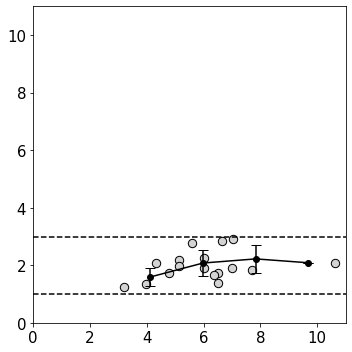

In [44]:
df_dat = pd.read_csv("../../../dat/curvature_maxmin_positions_summary.csv")

df_dat = df_dat.dropna()
X = df_dat["Distance of maxima from plus-end (μm)"].dropna()
Y = df_dat["Distance of minima from plus-end (μm)"].dropna()

nbins = 4
n, _ = np.histogram(X, bins=nbins)
sy, _ = np.histogram(X, bins=nbins, weights=Y)
sy2, _ = np.histogram(X, bins=nbins, weights=Y*Y)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)
plt.figure(figsize=(5,5))

plt.scatter(X,Y, s=70, color='lightgray',ec='k')
plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='o-',color='k',capsize=5,zorder=10)
# plt.xlabel("distance of needle from chromosome")
# plt.ylabel("distance of curv. minima from chromosome")
plt.axhline(3,color='k',ls='--')
plt.axhline(1,color='k',ls='--')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,11)
plt.ylim(0,11)
plt.tight_layout()
if save_images:
    plt.savefig("fig_outputs/WT_experimental_data.pdf")
plt.show()

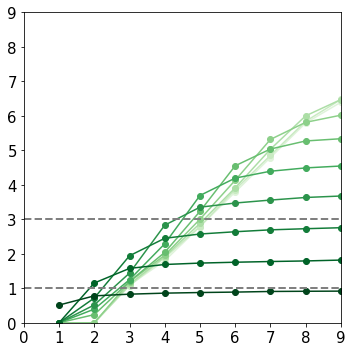

In [45]:
L_contour = 10
Fy = 1
xF_ls = [1,2,3,4,5,6,7,8,9]
num_sites = 1000
CL_tot = 100
amp2offset = 1e6
sigma_ls = [10,9,8,7,6,5,4,3,2,1]
CL_kv = 0.1
distribution = 'step'
spacing = 'deterministic' # 'deterministic' or 'random'
colors = pl.cm.Greens(np.linspace(0.15,1,len(sigma_ls)))

############################
# GENERATE SIMULATED DATA
# If the input conditions are not already in df, RUN simulation and append to df, else PASS 

sim_run = False
for sigma in sigma_ls:
    for xF in xF_ls:
        df_found = df.loc[(df['L_contour'] == L_contour) & (df['Fy'] == Fy) & (df['xF'] == xF) & (df['num_sites'] == num_sites)
                          & (df['CL_tot'] == CL_tot) & (df['amp2offset'] == amp2offset) & (df['sigma'] == sigma)
                          & (df['CL_kv'] == CL_kv) & (df['distribution'] == distribution) & (df['spacing'] == spacing)]

        if not df_found.empty:
            sim_run = False
#             print("Exists")
        elif df_found.empty:
            sim_run = True
            print("Does not exist. Running...")
            x_ls, y_ls, M_ls, Ky, fCLy, slope_ls, CL_pos, Fy_sim, Ry_sim, theta0_sim = CL_simulation(Fy, xF, L_contour, num_sites, CL_tot,
                                                                                                     amp2offset, sigma, CL_kv, distribution, spacing)

        if sim_run:
            df_new = df_new.append({'L_contour':L_contour,'Fy':Fy,'xF':xF,'num_sites':num_sites,
                                    'CL_tot':CL_tot,'amp2offset': amp2offset,'sigma': sigma,'CL_kv': CL_kv,
                                    'distribution': distribution,'spacing':spacing,
                                    'x_vals':x_ls,'y_vals':y_ls,'M_vals':M_ls,'Ky_val':Ky,'fCLy_val': -fCLy,
                                    'slope_vals':slope_ls,'CL_pos_vals':CL_pos, 'Fy_val':Fy_sim, 'Ry_val':Ry_sim, 
                                    'theta0_val':theta0_sim},ignore_index=True)    

df_new = df_new.drop_duplicates(["L_contour", "Fy", "xF", "num_sites", "CL_tot", "amp2offset",
                               "sigma", "CL_kv", "distribution", "spacing"], ignore_index=True)

df = df.append(df_new, ignore_index=True)
df.to_pickle("discreteCL_modeling.pkl")


############################
# PLOT RESULTS

kfiber_length_arr = np.zeros(len(xF_ls))
chrom_star_dist_arr = np.zeros(len(xF_ls))
chrom_needle_dist_arr = np.zeros(len(xF_ls))
x_star_array = np.zeros(len(xF_ls)) 
x_star_arrays = []
plt.figure(figsize=(5,5))
for n,sigma in enumerate(sigma_ls):
    for i,xF in enumerate(xF_ls):
        df_found = df.loc[(df['L_contour'] == L_contour) & (df['Fy'] == Fy) & (df['xF'] == xF) & (df['num_sites'] == num_sites) 
                          & (df['CL_tot'] == CL_tot) & (df['amp2offset'] == amp2offset) & (df['sigma'] == sigma)
                          & (df['CL_kv'] == CL_kv) & (df['distribution'] == distribution) & (df['spacing'] == spacing)]
        x_ls = df_found["x_vals"].values[0]
        y_ls = df_found["y_vals"].values[0]
        M_ls = df_found["M_vals"].values[0]
        CL_pos = df_found["CL_pos_vals"].values[0]  

        index_star = np.where(M_ls==M_ls[x_ls<xF].min())[0][0]
        x_star = x_ls[index_star]
        y_star = y_ls[index_star]
        y_interp = interp1d(x_ls,y_ls)
        xF = xF
        yF = y_interp(xF)

        chrom_star_dist = 0
        chrom_needle_dist = 0
        kfiber_length = 0
        for j in range(1,len(x_ls)):
            kfiber_length += np.sqrt((x_ls[j] - x_ls[j-1])**2+(y_ls[j] - y_ls[j-1])**2)
            if x_ls[j] <= x_star:
                chrom_star_dist += np.sqrt((x_ls[j] - x_ls[j-1])**2+(y_ls[j] - y_ls[j-1])**2)
            if x_ls[j] <= xF:
                chrom_needle_dist += np.sqrt((x_ls[j] - x_ls[j-1])**2+(y_ls[j] - y_ls[j-1])**2)

        kfiber_length_arr[i] = kfiber_length
        chrom_star_dist_arr[i] = chrom_star_dist
        chrom_needle_dist_arr[i] = chrom_needle_dist
        x_star_array[i] = x_star
        
    x_star_arrays.append(x_star_array.tolist())    
    
    plt.plot(xF_ls,x_star_array, 'o-', color=colors[n])
#     if sigma == 10:
#         plt.plot(xF_ls,x_star_array, color='k', lw=6,alpha=0.3, zorder=10)
# plt.title("Position of chromosome")
# plt.xlabel("distance from needle")
# plt.ylabel("distance from star")
plt.xlim(0,9)
plt.ylim(0,9)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axhline(1,color='gray',ls='--', lw=2)
plt.axhline(3,color='gray',ls='--', lw=2)
plt.tight_layout()
if save_images:
    plt.savefig("fig_outputs/tuning_sigmas.pdf")
plt.show()

# plt.figure(figsize=(8,5))
# model_ls  = [i[1:] for i in x_star_arrays]
# # data_ls.insert(0,df_dat["Distance of minima from plus-end (μm)"].tolist())

# color_ls = [rgb2hex(colors[i,:]) for i in range(colors.shape[0]) ]
# # color_ls.insert(0,'lightgray')

# mean_ls = [np.mean(i) for i in model_ls]
# # err_ls = [np.std(i)/np.sqrt(len(i)) for i in data_ls]
# err_ls = [np.std(i) for i in model_ls]

# dat_ls = df_dat["Distance of minima from plus-end (μm)"]

# sns.swarmplot(data=model_ls, palette = color_ls, size = 10)
# plt.errorbar([0,1,2,3],mean_ls[0:4], yerr = err_ls[0:4], \
#              elinewidth=6, fmt = '_',color = "k", marker = '_',markersize = 5, \
#              capsize = 7, zorder = 10, capthick=1.5)
# plt.axhline(min(dat_ls),color='grey', ls = "--")
# plt.axhline(max(dat_ls),color='grey', ls = "--")
# # plt.xticks(list(range(len(model_ls))), ("","","","","",""))
# plt.ylim(0,9)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.tight_layout()
# if save_images:
#     plt.savefig("fig_outputs/curvminima_comparison.pdf")
# plt.show()

sigma = 2


<Figure size 360x360 with 0 Axes>

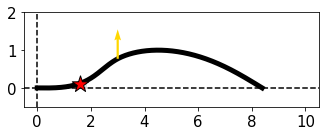

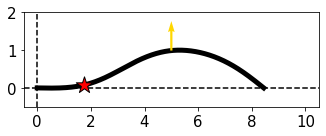

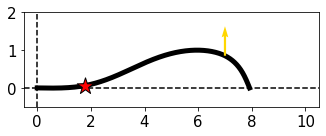

sigma = 10


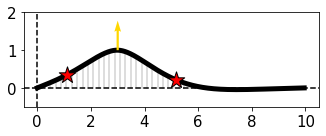

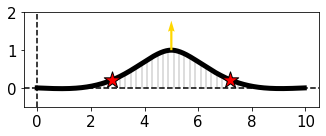

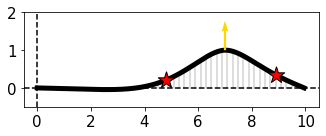

In [46]:
L_contour = 10
Fy = 1
xF_ls = [3,5,7]
num_sites = 1000
CL_tot = 100
amp2offset = 1e6
sigma_ls = [2,10]
CL_kv = 0.1
distribution = 'step'
spacing = 'deterministic' # 'deterministic' or 'random'
colors = pl.cm.Greens(np.linspace(0.15,1,len(sigma_ls)))

############################
# GENERATE SIMULATED DATA
# If the input conditions are not already in df, RUN simulation and append to df, else PASS 

sim_run = False
for sigma in sigma_ls:
    for xF in xF_ls:
        df_found = df.loc[(df['L_contour'] == L_contour) & (df['Fy'] == Fy) & (df['xF'] == xF) & (df['num_sites'] == num_sites)
                          & (df['CL_tot'] == CL_tot) & (df['amp2offset'] == amp2offset) & (df['sigma'] == sigma)
                          & (df['CL_kv'] == CL_kv) & (df['distribution'] == distribution) & (df['spacing'] == spacing)]

        if not df_found.empty:
            sim_run = False
#             print("Exists")
        elif df_found.empty:
            sim_run = True
            print("Does not exist. Running...")
            x_ls, y_ls, M_ls, Ky, fCLy, slope_ls, CL_pos, Fy_sim, Ry_sim, theta0_sim = CL_simulation(Fy, xF, L_contour, num_sites, CL_tot,
                                                                                                     amp2offset, sigma, CL_kv, distribution, spacing)

        if sim_run:
            df_new = df_new.append({'L_contour':L_contour,'Fy':Fy,'xF':xF,'num_sites':num_sites,
                                    'CL_tot':CL_tot,'amp2offset': amp2offset,'sigma': sigma,'CL_kv': CL_kv,
                                    'distribution': distribution,'spacing':spacing,
                                    'x_vals':x_ls,'y_vals':y_ls,'M_vals':M_ls,'Ky_val':Ky,'fCLy_val': -fCLy,
                                    'slope_vals':slope_ls,'CL_pos_vals':CL_pos, 'Fy_val':Fy_sim, 'Ry_val':Ry_sim, 
                                    'theta0_val':theta0_sim},ignore_index=True)    

df_new = df_new.drop_duplicates(["L_contour", "Fy", "xF", "num_sites", "CL_tot", "amp2offset",
                               "sigma", "CL_kv", "distribution", "spacing"], ignore_index=True)

df = df.append(df_new, ignore_index=True)
df.to_pickle("discreteCL_modeling.pkl")


############################
# PLOT RESULTS

kfiber_length_arr = np.zeros(len(xF_ls))
chrom_star_dist_arr = np.zeros(len(xF_ls))
chrom_needle_dist_arr = np.zeros(len(xF_ls))
x_star_array = np.zeros(len(xF_ls)) 
x_star_arrays = []
plt.figure(figsize=(5,5))
for n,sigma in enumerate(sigma_ls):
    print("sigma = %s"%sigma)
    for i,xF in enumerate(xF_ls):
        df_found = df.loc[(df['L_contour'] == L_contour) & (df['Fy'] == Fy) & (df['xF'] == xF) & (df['num_sites'] == num_sites) 
                          & (df['CL_tot'] == CL_tot) & (df['amp2offset'] == amp2offset) & (df['sigma'] == sigma)
                          & (df['CL_kv'] == CL_kv) & (df['distribution'] == distribution) & (df['spacing'] == spacing)]
        x_ls = df_found["x_vals"].values[0]
        y_ls = df_found["y_vals"].values[0]
        M_ls = df_found["M_vals"].values[0]
        CL_pos = df_found["CL_pos_vals"].values[0]  

        # flip profile
        L = x_ls[-1] - x_ls[0]
#         y_ls = np.flip(y_ls)
#         x_ls = L - np.flip(x_ls)
#         M_ls = np.flip(M_ls)
#         xF = L - xF
#         yF = y_interp(xF)
        
        # Normalize the magnitude of deflection
        y_ls = y_ls / np.max(y_ls)

        # Plot profile
        
        plt.figure(figsize=[5,2])
        plt.plot(x_ls,y_ls, color='k', lw=5, zorder=2)
        index_star = M_ls==M_ls[x_ls<xF].min()
        plt.scatter(x_ls[index_star], y_ls[index_star], marker="*",s=300, zorder=10,color="red",edgecolor="k")

        if sigma == 2:
            CL_plotting_freq = 10
        if sigma == 10:
            index_star = M_ls==M_ls[x_ls>xF].min()
            plt.scatter(x_ls[index_star], y_ls[index_star], marker="*",s=300, zorder=10,color="red",edgecolor="k")
            
            CL_plotting_freq = 2

        y_interp = interp1d(x_ls,y_ls)
        for i in range(0,len(CL_pos),CL_plotting_freq):
            if CL_pos[i] <= x_ls[-1]:
                plt.plot([CL_pos[i],CL_pos[i]],[0,y_interp(CL_pos[i])], color='lightgray', zorder=1)

        plt.quiver(xF,y_interp(xF), 0,Fy,color='gold',scale=10,zorder=3)

        plt.axhline(0,color='k', ls='--')
        plt.axvline(0,color='k', ls='--')
        plt.ylim(-np.max(y_ls)*0.5,np.max(y_ls)*2)
        plt.xlim(-0.5,10.5)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
#         plt.fill_between(x_ls,y_ls)

        plt.tight_layout()
        if save_images:
            plt.savefig("fig_outputs/profile_sigma%s_xF%s.pdf"%(sigma,int(xF)))
        plt.show() 
        

spring constant: 0.005


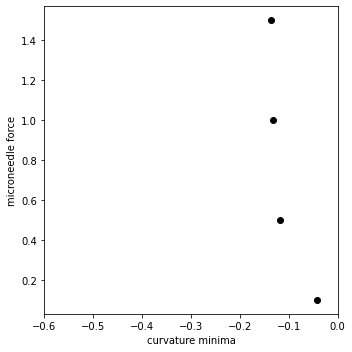

spring constant: 0.01


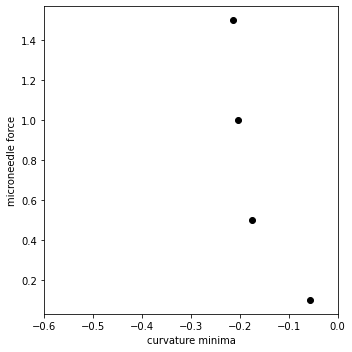

spring constant: 0.1


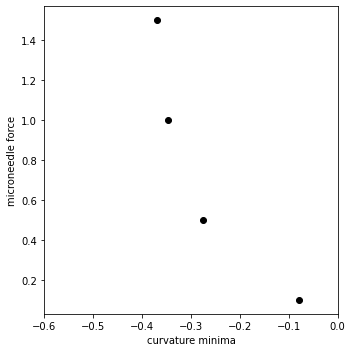

spring constant: 1


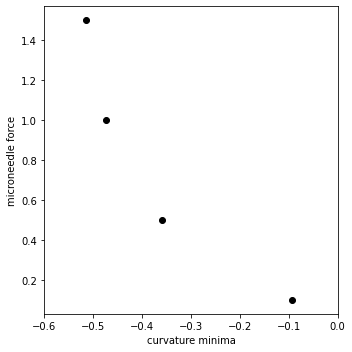

In [74]:
L_contour = 10
Fy_ls = [0.1,0.5,1,1.5]
xF = 7
num_sites = 1000
CL_tot = 100
amp2offset = 1e6
sigma = 3
CL_kv_ls = [0.005,0.01,0.1,1]
distribution = 'step'
spacing = 'deterministic' # 'deterministic' or 'random'

############################
# GENERATE SIMULATED DATA
# If the input conditions are not already in df, RUN simulation and append to df, else PASS 

sim_run = False
for CL_kv in CL_kv_ls:
    for Fy in Fy_ls:
        df_found = df.loc[(df['L_contour'] == L_contour) & (df['Fy'] == Fy) & (df['xF'] == xF) & (df['num_sites'] == num_sites)
                          & (df['CL_tot'] == CL_tot) & (df['amp2offset'] == amp2offset) & (df['sigma'] == sigma)
                          & (df['CL_kv'] == CL_kv) & (df['distribution'] == distribution) & (df['spacing'] == spacing)]

        if not df_found.empty:
            sim_run = False
#             print("Exists")
        elif df_found.empty:
            sim_run = True
            print("Does not exist. Running...")
            x_ls, y_ls, M_ls, Ky, fCLy, slope_ls, CL_pos, Fy_sim, Ry_sim, theta0_sim = CL_simulation(Fy, xF, L_contour, num_sites, CL_tot,
                                                                                                     amp2offset, sigma, CL_kv, distribution, spacing)
            print(Fy_sim,xF)
        if sim_run:
            df_new = df_new.append({'L_contour':L_contour,'Fy':Fy,'xF':xF,'num_sites':num_sites,
                                    'CL_tot':CL_tot,'amp2offset': amp2offset,'sigma': sigma,'CL_kv': CL_kv,
                                    'distribution': distribution,'spacing':spacing,
                                    'x_vals':x_ls,'y_vals':y_ls,'M_vals':M_ls,'Ky_val':Ky,'fCLy_val': -fCLy,
                                    'slope_vals':slope_ls,'CL_pos_vals':CL_pos, 'Fy_val':Fy_sim, 'Ry_val':Ry_sim, 
                                    'theta0_val':theta0_sim},ignore_index=True)    

df_new = df_new.drop_duplicates(["L_contour", "Fy", "xF", "num_sites", "CL_tot", "amp2offset",
                               "sigma", "CL_kv", "distribution", "spacing"], ignore_index=True)

df = df.append(df_new, ignore_index=True)
df.to_pickle("discreteCL_modeling.pkl")


############################
# PLOT RESULTS

x_star_arrays = []

for i,CL_kv in enumerate(CL_kv_ls):
    plt.figure(figsize=(5,5))
    print("spring constant:", CL_kv)
    for n,Fy in enumerate(Fy_ls):
        df_found = df.loc[(df['L_contour'] == L_contour) & (df['Fy'] == Fy) & (df['xF'] == xF) & (df['num_sites'] == num_sites) 
                          & (df['CL_tot'] == CL_tot) & (df['amp2offset'] == amp2offset) & (df['sigma'] == sigma)
                          & (df['CL_kv'] == CL_kv) & (df['distribution'] == distribution) & (df['spacing'] == spacing)]
        M_ls = df_found["M_vals"].values[0]
        Fy = df_found["Fy_val"].values[0]

        index_star = np.where(M_ls==M_ls[x_ls<xF].min())[0][0]
        y_interp = interp1d(x_ls,y_ls)
        xF = xF
        yF = y_interp(xF)
        M_star = M_ls[index_star]
        
        plt.scatter(M_star,Fy, color='k')
    plt.xlabel("curvature minima")
    plt.ylabel("microneedle force")
# plt.xlim(0,9)
    plt.xlim(-0.6,0)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
# plt.axhline(1,color='gray',ls='--', lw=2)
# plt.axhline(3,color='gray',ls='--', lw=2)
    plt.tight_layout()
# if save_images:
#     plt.savefig("fig_outputs/PRC1_gauss.pdf")
    plt.show()
    
    

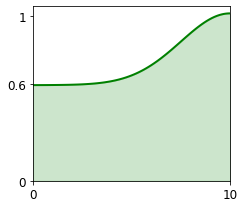

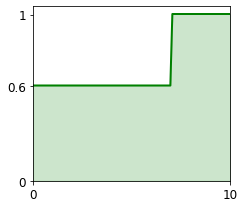

In [47]:
def eta_gauss(x, offset,amplitude, sigma):
    return offset+amplitude*np.exp(-x**2/(2*sigma**2))

def eta_step(x, offset,amplitude, sigma):
    if x < sigma:
        return amplitude+ offset
    elif x >= sigma:
        return offset

L_contour = 10
Fy = 1
num_sites = 1000
CL_tot = 100
amp2offset_ls = [0.75]
CL_kv = 0.1
spacing = 'deterministic' # 'deterministic' or 'random'

sigma = 2.5
for amp2offset in amp2offset_ls:
    plt.figure(figsize=(3.5,3))
    x_ls = np.linspace(0,10,100)
    y_ls = []
    L = 10
    offset = (1/L) + (amp2offset*sigma)
    amplitude = amp2offset*offset

    for x in x_ls:
        y_ls.append(eta_gauss(x,offset,amplitude, sigma))
    
    plt.plot(x_ls,y_ls,lw=2,color='green')
    plt.fill_between(x_ls,y_ls,color='green',alpha=0.2)
    plt.xlim(0,10)
    plt.yticks([0,1.99,3.4],[0,0.6,1],fontsize=12)
    plt.ylim(0.0,3.6)
    plt.gca().invert_xaxis()
    plt.xticks([10,0],[0,10],fontsize=12)
    plt.tight_layout()
    plt.savefig("fig_outputs/PRC1sigma_gauss.pdf")
    plt.show()

sigma = 3
for amp2offset in amp2offset_ls:
    plt.figure(figsize=(3.5,3))
    x_ls = np.linspace(0,10,100)
    y_ls = []
    L = 10
    offset = (1/L) + (amp2offset*sigma)
    amplitude = amp2offset*offset

    for x in x_ls:
        y_ls.append(eta_step(x,offset,amplitude, sigma))
    
    plt.plot(x_ls,y_ls,lw=2,color='green')
    plt.fill_between(x_ls,y_ls,color='green',alpha=0.2)
    plt.xlim(0,10)
    plt.yticks([0,2.34,4.1],[0,0.6,1],fontsize=12)
    plt.ylim(0.0,4.3)
    plt.gca().invert_xaxis()
    plt.xticks([10,0],[0,10],fontsize=12)
    plt.tight_layout()
    plt.savefig("fig_outputs/PRC1sigma_step.pdf")
    plt.show()
    

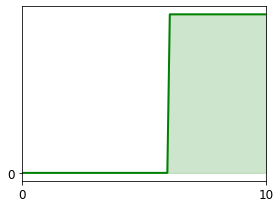

In [19]:

L_contour = 10
Fy = 1
num_sites = 1000
CL_tot = 100
amp2offset_ls = [1e10]
CL_kv = 0.1
spacing = 'deterministic' # 'deterministic' or 'random'


sigma = 4
for amp2offset in amp2offset_ls:
    plt.figure(figsize=(4,3))
    x_ls = np.linspace(0,10,100)
    y_ls = []
    L = 10
    offset = (1/L) + (amp2offset*sigma)
    amplitude = amp2offset*offset

    for x in x_ls:
        y_ls.append(eta_step(x,offset,amplitude, sigma))
    
    plt.plot(x_ls,y_ls,lw=2,color='green')
    plt.fill_between(x_ls,y_ls,color='green',alpha=0.2)
    plt.xlim(0,10)
    plt.yticks([0],[0],fontsize=12)
#     plt.yticks([],fontsize=12)
#     plt.ylim(0,5)
    plt.gca().invert_xaxis()
    plt.xticks([10,0],[0,10],fontsize=12)
    plt.tight_layout()
    plt.savefig("fig_outputs/sigma_plot.pdf")
    plt.show()
    